In [1]:
# Install Optuna if not already installed
!pip install optuna

import pandas as pd
import optuna
from sklearn.model_selection import GroupKFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Step 1: Load dataset
df = pd.read_csv('water_potability_final.csv')

# Step 2: Separate features and target
X = df.drop('Potability', axis=1)
y = df['Potability']

# Artificial groups for GroupKFold
groups = np.arange(len(X)) % 5

# Step 3: Train-test split
X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(
    X, y, groups, test_size=0.2, random_state=42
)

# Step 4: Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Define Optuna objective
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        "random_state": 42
    }

    rf = RandomForestClassifier(**params)
    gkf = GroupKFold(n_splits=5)
    scores = cross_val_score(
        rf, X_train_scaled, y_train,
        cv=gkf.split(X_train_scaled, y_train, groups_train),
        scoring='accuracy'
    )
    return scores.mean()

# Step 6: Run optimization (max 30 trials or 30 minutes)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, timeout=1800, show_progress_bar=True)

# Step 7: Train model with best params
best_params = study.best_params
rf_best = RandomForestClassifier(**best_params, random_state=42)
rf_best.fit(X_train_scaled, y_train)

# Step 8: Evaluate model
y_pred = rf_best.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Step 9: Display results
results = pd.DataFrame([{
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1
}])

print("\n Water Potability Model Performance:\n", results)
print("\n Best Parameters Found by Optuna:\n", best_params)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 5.8 MB/s eta 0:00:00


[I 2025-11-16 08:01:37,022] A new study created in memory with name: no-name-2062ca55-db96-4388-8651-ec19147ecf5c


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-11-16 08:01:49,117] Trial 0 finished with value: 0.7837715634154414 and parameters: {'n_estimators': 233, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 0 with value: 0.7837715634154414.
[I 2025-11-16 08:02:04,448] Trial 1 finished with value: 0.7866783118922421 and parameters: {'n_estimators': 126, 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 1 with value: 0.7866783118922421.
[I 2025-11-16 08:02:40,799] Trial 2 finished with value: 0.7898908323499225 and parameters: {'n_estimators': 283, 'max_depth': 21, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 2 with value: 0.7898908323499225.
[I 2025-11-16 08:02:52,458] Trial 3 finished with value: 0.7943505355619586 and parameters: {'n_estimators': 200, 'max_depth': 28, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.7943505355619586.


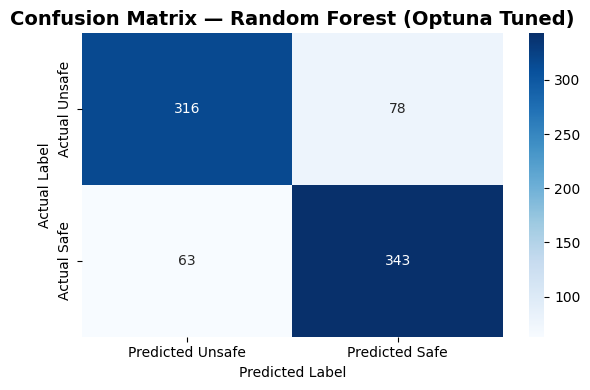

In [2]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Unsafe', 'Predicted Safe'],
            yticklabels=['Actual Unsafe', 'Actual Safe'])

plt.title('Confusion Matrix — Random Forest (Optuna Tuned)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.tight_layout()
plt.show()
